In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,f1_score
from sklearn.metrics import average_precision_score, precision_score, recall_score, accuracy_score,precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике. 
Например, введите следующие параметры:

сколько денег в среднем приносит один пользователь в месяц;

сколько денег в среднем вы будете вкладывать в удержание одного пользователя;

с какой вероятностью пользователь примет ваше предложение;

сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.



1.Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

In [172]:
ARPU=300 #сколько денег в среднем приносит один пользователь в месяц;
DPU=ARPU/100*15 #сколько денег в среднем вы будете вкладывать в удержание одного пользователя
AP =0.5 #с какой вероятностью пользователь примет ваше предложение;
TopU=0.03 #сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.

In [53]:
DPU

45

Сначала загрузим данные и подготовим модель

In [2]:
data=pd.read_csv('orange_small_churn_train_data.csv')
data=data.drop('ID',1)

In [3]:
X_data=data.iloc[:,:230]
y_data=data.iloc[:,230:]

In [4]:
def preproceccing(X,number_features,fill,coding):
    #Отбросим колонки где данных вообще нет
    zero=list()
    print ((X.shape[0]))
    for var in X.columns:
        if (sum(X[var].isnull()) / float(X.shape[0]))>0.9:zero.append(var)
    print 'Колонки ,которые мы отбросили', len(zero)
    real_columns=X.columns.drop(zero)
    print 'Осталось:',len(real_columns)
    X=X[real_columns]
    #Из 230 колонок выбросли уже 154 где нет данных или они заполнены менее чем на 10%
    #разделим на вещ. и категориальные и заполним вещ.пропуски средними,а пропуски категории "NA"
    num_columns=[]
    cat_columns=[]
    for var in X.columns:
        if (X[var].dtype=='float64')or (X[var].dtype=='int64'):num_columns.append(var) 
        else: cat_columns.append(var) #X[var].dtype=='object'
    num_data=X[num_columns]
    print 'num_data',num_data.shape
    cat_data=X[cat_columns]
    print 'cat_data',cat_data.shape
    if fill==0: 
        num_data_mean=num_data.fillna(0)
        print fill
    else:
        num_data_mean=num_data.fillna(num_data.mean())
        print fill
    cat_data=cat_data.fillna('NA')
    #Мы видели что есть кат признаки с кол-вом категорий более 10000.Возможно это фамилии или персональные данные,
    #которые сейчас нам будут только мешать.
    #Ясно что эти признаки надо убрать, будут только шуметь.Оставим только только признаки с числом категорий меньше
    #number_features
    k=0
    new=list()
    for var in cat_columns:
        if len(cat_data[var].value_counts())!=1 and len(cat_data[var].value_counts())<number_features : 
            k+=1
            #print 'X_train',var,len(cat_data.iloc[:40000,:][var].value_counts()),'   X_test',var,len(cat_data.iloc[40000:,:][var].value_counts())
            new.append(var)
    #print new
    print 'Признаки которые мы оставили',k
    cat=cat_data[new]
    cat_columns=cat.columns.tolist()
    feature_names=num_columns+cat_columns
    #Кодируем их
    if coding=='OneHot':
        cat_code = cat.apply(LabelEncoder().fit_transform)
        cat_code = OneHotEncoder(sparse=False).fit_transform(cat_code)
        print (coding)
    if coding=='Label':
        cat_code = cat.apply(LabelEncoder().fit_transform)
        print (coding)
    print cat_code.shape
    #Масштабируем признаки
    num_data_mean=StandardScaler().fit_transform(num_data_mean)
    #Собираем признаки вместе
    X_select=np.hstack( (num_data_mean,cat_code))
    print X_select.shape
        
    return  X_select,feature_names

In [58]:
X_select,feature_names = preproceccing(X_data,number_features=1000,fill=1,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#балансировка
np.random.seed(1)
indices_to_add = np.random.randint(np.sum(y==1),size=(np.sum(y==-1)-np.sum(y==1)))
X_a =X[y == 1,:][indices_to_add,:]
X_add=np.vstack( (X,X_a) )
ones= np.ones((np.sum(y==-1)-np.sum(y==1)))
y_add=np.hstack((y, ones))
y_add.shape
#обучение
clf=GradientBoostingClassifier(n_estimators=200,learning_rate=0.05,random_state=1)
cv=StratifiedKFold(n_splits=3)
f1=cross_val_score(clf, X_add, y_add, scoring='f1',cv=cv)
avr=cross_val_score(clf,X_add,y_add,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
num_data (40000, 42)
cat_data (40000, 34)
1
Признаки которые мы оставили 25
Label
(40000, 25)
(40000L, 67L)
f1                0.721324266024
average_precision 0.772521101813
roc_auc           0.790392172492


In [59]:
clf.fit(X_add, y_add)
gb_predictions=clf.predict_proba(X_holdout)
gb_predictions1=clf.predict(X_holdout)
auc=roc_auc_score(y_holdout,gb_predictions[:,1]  )
avp=average_precision_score(y_holdout,gb_predictions[:,1]  )
print 'avp_test              ',avp
print 'roc_auc_test          ',auc

avp_test               0.210569063222
roc_auc_test           0.739237465231


-Cформируем датафрейм с вероятностью для класса отток и реальными тестовыми метками класса.
-Отранжируем по уменьшению вероятности тех кто по мнению классификатора склонен к оттоку,т.е. вероятностью принадлежности к классу 1
-Вычисляем топ-3% пользователей

In [175]:
predict = pd.DataFrame({'predict_label':gb_predictions[:,1],'test_label':y_holdout})
churn=predict.sort_values('predict_label',ascending=False)
top_users=churn.head(int(TopU*len(churn)))
print len(top_users)
print len(churn)

360
12000


In [176]:
cost = DPU * len(top_users)
real_churn=top_users[top_users.test_label == 1]
print len(real_churn)
false_churn=top_users[top_users.test_label ==-1]
revenue = ARPU * AP * len(real_churn)
profit_loss = revenue-cost
print 'Сумма, потраченная на компанию: ', cost
print 'Сумма, которую принесут реально удержанные клиенты: ', revenue
print 'Прибыль:', profit_loss

119
Сумма, потраченная на компанию:  16200
Сумма, которую принесут реально удержанные клиенты:  17850.0
Прибыль: 1650.0


2.Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим

In [ ]:
#Поэкспериментруем с топ % и посмотрим визуально на графике

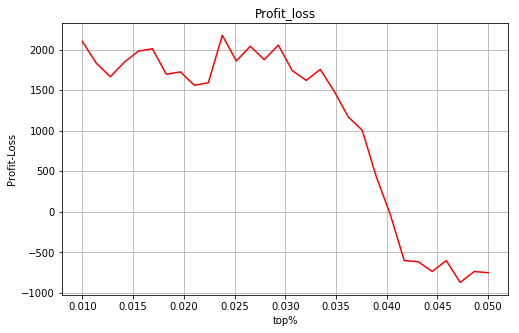

In [177]:
n=np.linspace(0.01,0.05,30)#величина в процентах
profit_loss=np.ones(30)
for i in range (30):
    TopU=n[i]
    top_users=churn.head(int(TopU*len(churn)))
    cost = DPU * len(top_users)
    real_churn=top_users[top_users.test_label == 1]
    revenue= ARPU * AP * len(real_churn)
    profit_loss[i] = revenue-cost
plt.figure(figsize=(8, 5))
plt.plot(n, profit_loss, color='red')
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.grid()
#plt.xlim(0.0,0.14)
plt.xlabel("top%")
plt.ylabel("Profit-Loss")
plt.title("Profit_loss")

In [178]:
print 'Максимум достигается при размере топа, %',n[np.argmax(profit_loss)]*100,'эффект,руб.', profit_loss.max()

Максимум достигается при размере топа, % 2.37931034483 эффект,руб. 2175.0


Если мы внимательно посмотрим на формулу профита , то при неизменных ARPU,DPU,AP на прибыль влияет точность модели и порог вероятности .У нас есть метрика precision_recall_curve, которая как раз выдает набор presicion и thresholds.Точка на кривой,определяющая порог и точность - соответствующий максимум прибыли, однозначно определяет топ-% пользователей текущей модели. 

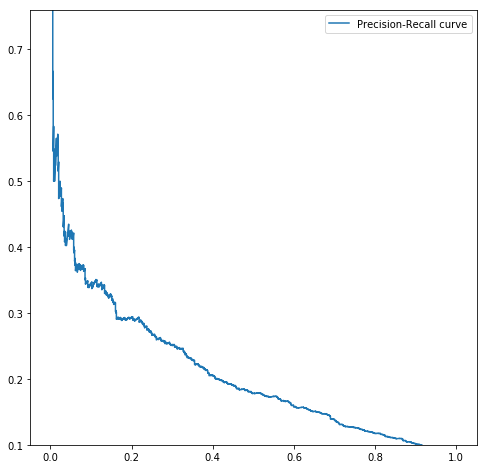

In [179]:
precision, recall, thresholds =  precision_recall_curve(y_holdout, gb_predictions[:,1])
plt.figure(figsize=(8, 8))
plt.ylim(0.1,0.76)
plt.plot(recall, precision, label="Precision-Recall curve")
plt.legend()

In [180]:
max_profit =0
churn=predict.sort_values('predict_label',ascending=False)
profit_loss=[]
top=[]
TopU=0
for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    top_users=churn[churn.predict_label>t]
    cost = DPU * len(top_users)
    real_churn=float(len(top_users))*p
    revenue= ARPU * AP * real_churn
    profit_loss.append(revenue-cost)
    top.append(float(len(top_users))/float(len(churn)))
    if profit_loss[-1]>max_profit:
        max_profit=profit_loss[-1]
        max_t=t
        max_p=p
        max_r=r
        TopU=top[-1]
print "Лучший эффект достигается при использовании топ-% пользователей" , round(TopU*100,2)
print "Соотв. precision:", max_p
print "Соотв. recall:   ", max_r
print "Соотв. порог кл.:", max_t
print "Соотв. эффект   :", float(max_profit), "руб."
profit1=max_profit

Лучший эффект достигается при использовании топ-% пользователей 2.68
Соотв. precision: 0.346749226006
Соотв. recall:    0.125419932811
Соотв. порог кл.: 0.77160946837
Соотв. эффект   : 2257.9876161 руб.


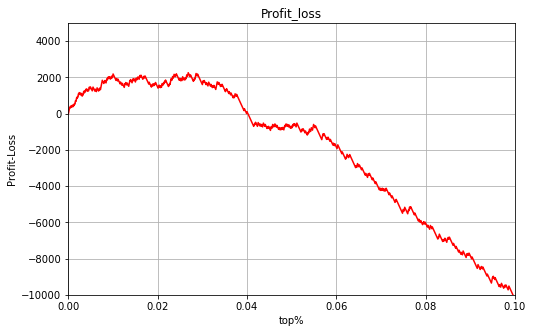

In [181]:
plt.figure(figsize=(8, 5))
plt.plot(top, profit_loss, color='red')
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.grid()
plt.xlim(0.0,0.1)
plt.ylim(-10000,5000)
plt.xlabel("top%")
plt.ylabel("Profit-Loss")
plt.title("Profit_loss")

3.Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа? 

Поэкспериментруем с затратами на удержание в % от ARPU и вероятностью принятия скидки

Скидка, % 10.0 Вероятность принятия 0.3
Лучший эффект достигается при использовании топ-% пользователей 1.0
Соотв. precision: 0.421487603306
Соотв. recall:    0.057110862262
Соотв. порог кл.: 0.812743703224
Соотв. эффект   : 952.066115702 руб.
Скидка, % 10.0 Вероятность принятия 0.5
Лучший эффект достигается при использовании топ-% пользователей 5.53
Соотв. precision: 0.293233082707
Соотв. recall:    0.21836506159
Соотв. порог кл.: 0.724681371178
Соотв. эффект   : 9286.01503759 руб.
Скидка, % 10.0 Вероятность принятия 0.7
Лучший эффект достигается при использовании топ-% пользователей 9.87
Соотв. precision: 0.24641350211
Соотв. recall:    0.326987681971
Соотв. порог кл.: 0.663915011173
Соотв. эффект   : 25748.2531646 руб.
Скидка, % 15.0 Вероятность принятия 0.3
Лучший эффект достигается при использовании топ-% пользователей 0.24
Соотв. precision: 0.566666666667
Соотв. recall:    0.0190369540873
Соотв. порог кл.: 0.857234250283
Соотв. эффект   : 174.0 руб.
Скидка, % 15.0 Вероятность при

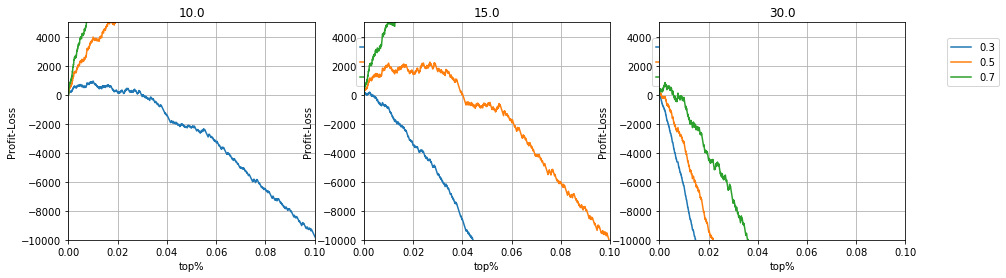

In [148]:
ARPU=300.0
plt.figure(figsize=(15,4))
i = 0
for d in [0.10, 0.15, 0.3]:# скидка на услуги для удержания клиента, % от ARPU     
    i += 1
    ax = plt.subplot(1, 3, i)
    for AP in [0.3, 0.5, 0.7]:  # Вероятность удержания пользователя предлагаемой скидкой
        max_profit =0
        profit_loss=[]
        top=[]
        TopU=0
        for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
            top_users=churn[churn.predict_label>t]
            cost = ARPU*d * len(top_users)
            real_churn=float(len(top_users))*p
            revenue= ARPU * AP * real_churn
            profit_loss.append(revenue-cost)
            top.append(float(len(top_users))/float(len(churn)))
            if profit_loss[-1]>max_profit:
                max_profit=profit_loss[-1]
                max_t=t
                max_p=p
                max_r=r
                TopU=top[-1]
        print 'Скидка, %',d*100, 'Вероятность принятия',AP
        print "Лучший эффект достигается при использовании топ-% пользователей" , round(TopU*100,2)
        print "Соотв. precision:", max_p
        print "Соотв. recall:   ", max_r
        print "Соотв. порог кл.:", max_t
        print "Соотв. эффект   :", float(max_profit), "руб."
        plt.plot(top, profit_loss, label=str(AP))
        plt.title(str(d*100))
        plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
        plt.grid()
        plt.xlim(0.0,0.1)
        plt.ylim(-10000,5000)
        plt.xlabel("top%")
        plt.ylabel("Profit-Loss")

In [ ]:
#Чем меньше скидка и чем с большей вероятностью принята,тем больше эффект.
#Лучший результат Скидка 10% и вероятность ее принятия 0.7

4.Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным

In [ ]:
#Модель теряет смысл при скидках от 30% или вероятности принятия меньше 0,3

5.Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

In [ ]:
#Точность модели здесь главная метрика.Оцениваем по ней

In [ ]:
ARPU=300 #сколько денег в среднем приносит один пользователь в месяц;
DPU=ARPU/100*15 #сколько денег в среднем вы будете вкладывать в удержание одного пользователя
AP =0.5 #с какой вероятностью пользователь примет ваше предложение;

In [153]:
max_profit =0
churn=predict.sort_values('predict_label',ascending=False)
profit_loss=[]
top=[]
TopU=0
for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    top_users=churn[churn.predict_label>t]
    cost = DPU * len(top_users)
    real_churn=float(len(top_users))*(p+0.01)# увеличим точность на 1%
    revenue= ARPU * AP * real_churn
    profit_loss.append(revenue-cost)
    top.append(float(len(top_users))/float(len(churn)))
    if profit_loss[-1]>max_profit:
        max_profit=profit_loss[-1]
        max_t=t
        max_p=p
        max_r=r
        TopU=top[-1]
print "Лучший эффект достигается при использовании топ-% пользователей" , round(TopU*100,2)
print "Соотв. precision:", max_p
print "Соотв. recall:   ", max_r
print "Соотв. порог кл.:", max_t
print "Соотв. эффект   :", float(max_profit), "руб."
profit2=max_profit

Лучший эффект достигается при использовании топ-% пользователей 2.68
Соотв. precision: 0.346749226006
Соотв. recall:    0.125419932811
Соотв. порог кл.: 0.77160946837
Соотв. эффект   : 2740.9876161 руб.


In [165]:
max_profit =0
churn=predict.sort_values('predict_label',ascending=False)
profit_loss=[]
top=[]
TopU=0
for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    top_users=churn[churn.predict_label>t]
    cost = DPU * len(top_users)
    real_churn=float(len(top_users))*(p+0.03)# увеличим точность на 3%
    revenue= ARPU * AP * real_churn
    profit_loss.append(revenue-cost)
    top.append(float(len(top_users))/float(len(churn)))
    if profit_loss[-1]>max_profit:
        max_profit=profit_loss[-1]
        max_t=t
        max_p=p
        max_r=r
        TopU=top[-1]
print "Лучший эффект достигается при использовании топ-% пользователей" , round(TopU*100,2)
print "Соотв. precision:", max_p
print "Соотв. recall:   ", max_r
print "Соотв. порог кл.:", max_t
print "Соотв. эффект   :", float(max_profit), "руб."
profit3=max_profit

Лучший эффект достигается при использовании топ-% пользователей 2.86
Соотв. precision: 0.343023255814
Соотв. recall:    0.132138857783
Соотв. порог кл.: 0.767991374254
Соотв. эффект   : 3757.04651163 руб.


In [166]:
print 'При улучшении точности на 1% экономический эффект: ', round(profit2-profit1, 2), 'руб.'
print 'При улучшении точности на 3% экономический эффект: ', round(profit3-profit1, 2), 'руб.'
print 'Увеличение, соответственно, на ', round(100*(profit2-profit1)/profit1,1), '% и',round(100*(profit3-profit1)/profit1,1), '%'

При улучшении точности на 1% экономический эффект:  483.0 руб.
При улучшении точности на 3% экономический эффект:  1499.06 руб.
Увеличение, соответственно, на  21.4 % и 66.4 %


6.Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

In [169]:
#Думаю,да. 
#Асолютные цифры небольшие,но при увеличении точности процентов на 15-20% (возможно ли?) и топа эффект будет видимым.